In [470]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import math
pd.set_option('display.max_rows', 22)
!date

%load_ext autoreload
%autoreload 2

Fri Feb  7 00:31:48 PST 2020
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [820]:
# the complex part of the TopDown Algorithm is an optimization step that
# removes illogical counts such as negatives, using constrained convex optimization

# in this minimal example, I will optimize to find counts that are "close" to the dp counts,
# are non-negative, and have race-stratified sums that match the precise total sum for both minority and majority
# groups

import pyomo.environ
from pyomo.core import *
from pyomo.opt import SolverFactory


# Abie's minimal DP model, reproducing undercounts in AIAN pop found by Akee. Parameterized detailed area population.

In [822]:
# add Geometric noise, to make counts differentially private
def GDPC(epsilon, exact_counts):
    """ Geometric DP Counts
    Parameters
    ----------
    epsilon : float-able
    exact_counts : pd.Series
    
    Results
    -------
    returns dp_counts, a pd.Series with index matching exact_counts"""
    
    z = float(epsilon)

    all_errors = (np.random.geometric(z, size=len(exact_counts))
                    - np.random.geometric(z, size=len(exact_counts)))
    dp_counts = exact_counts + all_errors
    return dp_counts


In [824]:
def nonnegative_optimize(imprecise_counts, control_total):
    """optimize the imprecise counts so that they sum to
    the control total and are non-negative
    
    Parameters
    ----------
    imprecise_counts : list-like of floats
    control_total : float
    
    Results
    -------
    returns optimized_counts, which are close to imprecise counts,
    but not negative, and match control total in aggregate
    """
    imprecise_counts = list(imprecise_counts)
    
    model = ConcreteModel()
    model.I = range(len(imprecise_counts))
    model.x = Var(model.I, within=NonNegativeReals)
    model.objective = Objective(
        expr=sum((model.x[i] - imprecise_counts[i])**2 for i in model.I))
    model.constraint = Constraint(
        expr=summation(model.x) == control_total)
    
    solver = SolverFactory('ipopt')
    results = solver.solve(model, options={'acceptable_tol':1e-4}, tee=False)
    optimized_counts = [value(model.x[i]) for i in model.I]
        
    return np.array(optimized_counts)

## set parameters

In [699]:
seed = 1
np.random.seed(seed) # set random seed for reproducibility

In [826]:
epsilon = '0.1'
K = 10_000  # number of areas at most-detailed level

# parameters for the distribution of population counts per detailed area
a = .2 # smaller causes greater undercount
b = 10
n_k = 3e3* np.random.beta(a, b, K) # number of individuals in area k


overall_minority_share = 0.05 # 2% of total population is in minority race group
segregation_factor = 1 # tunable parameter controlling how many areas are "majority minority". smaller *eventually* increases bias rapidly

minority_share = np.random.beta(overall_minority_share/segregation_factor,
                                (1-overall_minority_share)/segregation_factor, size=K)

print('Minority majority areas if size was large:', (minority_share > .5).sum(), 'out of', K)

Minority majority areas if size was large: 377 out of 10000


## checkout parameters

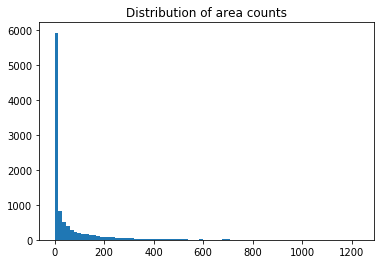

589133.186546268


In [808]:
# checkout distribution of area sizes
plt.hist(n_k, bins = 80)
plt.title("Distribution of area counts")
plt.show()
total_pop = sum(n_k)
print(total_pop)

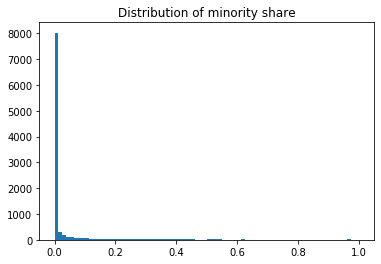

580808.8358850431


In [819]:
# checkout distribution of minority share
plt.hist(minority_share, bins = 80)
plt.title("Distribution of minority share")
plt.show()
total_pop = sum(n_k)
print(total_pop)

In [827]:
#see county distribution notebook. these two distributions aren't actually independent, as modeled here.

## run sim

In [810]:
# simulate race-/location-stratified counts
precise_minority_count = np.random.binomial(n_k.astype(int), minority_share)
precise_majority_count = n_k - precise_minority_count

print('Minority majority areas with size from sim:',
      (precise_minority_count > precise_majority_count).sum(), 'out of', K)

Minority majority areas with size from sim: 245 out of 10000


In [811]:
print('Overall minority share if size was large :', 100*overall_minority_share, '%')
print('Overall minority share with size from sim:', 100*precise_minority_count.sum()/(n_k.mean()*K), '%')

Overall minority share if size was large : 5.0 %
Overall minority share with size from sim: 5.110389414064253 %


In [812]:
# Add geometric noise
dp_minority_count = GDPC(epsilon, precise_minority_count)
dp_majority_count = GDPC(epsilon, precise_majority_count)

In [813]:
print('DP estimate of minority share:', 100*dp_minority_count.sum()/(dp_minority_count + dp_majority_count).sum(), '%')

DP estimate of minority share: 5.1995116061570865 %


In [814]:
# but this probably includes illogical counts, such as negative numbers of the minority population
print('Number of negative minority counts in DP estimate:', (dp_minority_count < 0).sum())
print('Number of negative majority counts in DP estimate:', (dp_majority_count < 0).sum())

Number of negative minority counts in DP estimate: 4486
Number of negative majority counts in DP estimate: 2464


In [815]:
# optimize to remove all negatives, keep total constant
nn_minority_count = nonnegative_optimize(dp_minority_count, precise_minority_count.sum())
nn_majority_count = nonnegative_optimize(dp_majority_count, precise_majority_count.sum())

In [817]:
# results
minority_majority_area = (minority_share > .5)
print(f'Minority counts in minority-majority areas')
print(f'''precise {precise_minority_count[minority_majority_area].sum()},
     dp {dp_minority_count[minority_majority_area].sum()},
non-neg {nn_minority_count[minority_majority_area].sum()}''')
print(f'pct diff {1-(nn_minority_count[minority_majority_area].sum()/precise_minority_count[minority_majority_area].sum())}')

Minority counts in minority-majority areas
precise 17064,
     dp 17191,
non-neg 14329.800005950765
pct diff 0.16023206716181637


In [744]:
# output.to_csv("/share/scratch/users/beatrixh/02_06_2020/seed_{}_minority_{}_nkalpha_{}_nkbeta_{}.csv".format(seed,
#                                                                                               overall_minority_share,
#                                                                                               a,b),
#              index=False)